# Integrating the moment equations - mRNA

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)

---

In [144]:
import pickle
import dill # Library that we will use to export lambdify functions

# Our numerical workhorses
import numpy as np
import scipy as sp
import pandas as pd

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'
figdir = '../../fig/moment_dynamics_numeric/'

### $\LaTeX$ macros
$\newcommand{kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{kron}{k^{(r)}_{\text{on}}}$
$\newcommand{kroff}{k^{(r)}_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$

# Numerically integrating the moment equations.

In this notebook we will numerically integrate the differential equations for the mRNA distribution moments for the two-state unregulated promoter.

Up to this stage we wrote the chemical master equation in matrix notation and did some tricks when it came to compute the $n^{\text{th}}$ moment. Now we will use the equations we obtained for the time derivative of the mRNA distribution moments and try to solve them.

# mRNA
---
## Importing the steady-state solutions.

Before continuing with the numerical integration of the solutions, let's import the steady state moments analytically derived elsewhere to compare these results with the long-term dynamics.

In [84]:
# Import two-state mRNA moments
# Parameters are feed in the following order:
# (kp_on, kp_off, rm, gm)
with open(tmpdir + 'two_state_mRNA_lambdify.dill', 'rb') as file:
    first_unreg_m = dill.load(file)
    second_unreg_m = dill.load(file)
    third_unreg_m = dill.load(file)
    
# Import two-state mRNA moments
# Parameters are feed in the following order:
# (kr_on, kr_off, kp_on, kp_off, rm, gm)
with open(tmpdir + 'three_state_mRNA_lambdify.dill', 'rb') as file:
    first_reg_m = dill.load(file)
    second_reg_m = dill.load(file)
    third_reg_m = dill.load(file)

### Zeroth moment 
In order to solve for the two- and three-state promoter we have two equations to use
$$
\bb{1} = \mathbf{u} \cdot \left\langle \mathbf{m}^0 \right\rangle,
$$
where $u = (1, 1)$ for the unregulatd promoter and $u = (1, 1, 1)$ for the regulated case and $\left\langle \mathbf{m}^0 \right\rangle$ is the vector containing all the states, and
$$
{d \over dt} \ee{\bb{m}^0} = \mathbf{K}_m \left\langle \mathbf{m}^0 \right\rangle.
$$

Let's now define this system.

In [85]:
def dm0dt(m0, t, Kmat):
    '''
    function to integrate dm0 / dt using scipy.integrate.odeint
    Parameters
    ----------
    m0 : array-like.
        Array containing the zeroth moment of the states of the
        promoter.
        m0[0] = m0_P (RNAP bound)
        m0[1] = m0_E (Empty promoter)
        m0[2] = m0_R (Repressor bound) NOTE: This state is optional
    t : array-like.
        Time array
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Returns
    -------
    dm0 / dt
    '''
    # Compute the master equation
    return np.dot(Kmat, m0)

### First moment two-state promoter

Now that we have the zeroth moment that indicates the probability of being on either state let's now compute the first moment. For this we have the matrix equation
$$
{d \over dt}\ee{\bb{m}^1} = 
\left( \mathbf{K}_m - \mathbf{\Gamma}_m  \right)\ee{\bb{m}^1}
             + \mathbf{R}_m \left\langle \mathbf{m}^0 \right\rangle.
$$

Let's define a function to compute this system.

**Note:** Since the solution of the first moment depends on the solution of the zeroth moment the function will call the zeroth moment function and the system will solve all equations sumultaneously.

In [72]:
def dm1dt(m, t, Kmat, Rmat, Gmat):
    '''
    function to integrate dm1 / dt using scipy.integrate.odeint
    Parameters
    ----------
    m : array-like.
        Array containing the zeroth and first moment of the states of the 
        promoter.
        Unregulated
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m1_P (RNAP bound)
        m[3] = m1_P (RNAP bound)
        ---------
        Regulated:
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m0_R (Repressor bound) 
        m[3] = m1_P (RNAP bound)
        m[4] = m1_E (Empty promoter)
        m[5] = m1_R (Repressor bound) 
    t : array-like.
        Time array
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rmat : array-like.
        Matrix containing the production rate at each of the states.
    Gmat : array-like.
        Matrix containing the degradation rate at each of the states.   
        
    Returns
    -------
    dm0/dt and dm1/dt
    '''
    # Obtain the zeroth and first moment based on the size 
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = m[0:2]
        m1 = m[2::]
    elif Kmat.shape[0] == 3:
        m0 = m[0:3]
        m1= m[3::]
    
    # Compute the moment equations for the:
    # Zeroth moment
    dm0dt_eq = np.dot(Kmat, m0)
    # First moment
    dm1dt_eq = np.dot((Kmat - Gmat), m1) + np.dot(Rmat, m0)
    
    return np.append(dm0dt_eq, dm1dt_eq) 

### Second moment two-state promoter

For the second moment we have an equation of the form
$$
{d\ee{\bb{m}^2} \over dt} = \left( \mathbf{K}^u_m - 2 \mathbf{\Gamma}^u_n \right) 
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 2 \mathbf{R}^u_m + \mathbf{\Gamma}^u_m \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \mathbf{R}^u_m
             \left\langle \mathbf{m}^0 \right\rangle
$$

Let's again define the function to compute the second moment (including the zeroth and first moment again)

In [79]:
def dm2dt(m, t, Kmat, Rmat, Gmat):
    '''
    function to integrate dm2 / dt using scipy.integrate.odeint
    Parameters
    ----------
    m : array-like.
        Array containing the zeroth, first and second moment of the 
        states of the promoter.
        Unregulated
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m1_P (RNAP bound)
        m[3] = m1_P (Empty promoter)
        m[4] = m2_P (RNAP bound)
        m[5] = m2_P (Empty promoter)
        ---------
        Regulated:
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m0_R (Repressor bound) 
        m[3] = m1_P (RNAP bound)
        m[4] = m1_E (Empty promoter)
        m[5] = m1_R (Repressor bound) 
        m[6] = m2_P (RNAP bound)
        m[7] = m2_E (Empty promoter)
        m[8] = m2_R (Repressor bound) 
    t : array-like.
        Time array
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rmat : array-like.
        Matrix containing the production rate at each of the states.
    Gmat : array-like.
        Matrix containing the degradation rate at each of the states.   
        
    Returns
    -------
    dm0/dt and dm1/dt
    '''
    # Obtain the zeroth and first moment based on the size 
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = m[0:2]
        m1 = m[2:4]
        m2 = m[4::]
    elif Kmat.shape[0] == 3:
        m0 = m[0:3]
        m1= m[3:6]
        m2= m[6::]
    
    # Compute the moment equations for the:
    # Zeroth moment
    dm0dt_eq = np.dot(Kmat, m0)
    # First moment
    dm1dt_eq = np.dot((Kmat - Gmat), m1) + np.dot(Rmat, m0)
    # Second moment
    dm2dt_eq = np.dot((Kmat - 2 * Gmat), m2) + np.dot((2 * Rmat + Gmat), m1) +\
                np.dot(Rmat, m0)
    
    return np.append(dm0dt_eq, np.append(dm1dt_eq, dm2dt_eq))

### Third moment two-state promoter

For the third moment we have a matrix equatio of the form
$$
{d\ee{\bb{m}^3} \over dt} = \left( \mathbf{K}_m - 3 \mathbf{\Gamma}_n \right) 
             \left\langle \mathbf{m}^3 \right\rangle
             + \left( 3 \mathbf{R}_m + 3 \mathbf{\Gamma}_m \right)
             \left\langle \mathbf{m}^2 \right\rangle
             + \left( 3 \mathbf{R}_m - \mathbf{\Gamma}_m \right)
             \left\langle \mathbf{m}^1 \right\rangle
             + \mathbf{R}_m
             \left\langle \mathbf{m}^0 \right\rangle
$$

As befor we will define a function that computes all moments.

In [80]:
def dm3dt(m, t, Kmat, Rmat, Gmat):
    '''
    function to integrate dm3 / dt using scipy.integrate.odeint
    Parameters
    ----------
    m : array-like.
        Array containing the zeroth, first, second and third moment 
        of the states of the promoter.
        Unregulated
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m1_P (RNAP bound)
        m[3] = m1_P (Empty promoter)
        m[4] = m2_P (RNAP bound)
        m[5] = m2_P (Empty promoter)
        m[6] = m3_P (RNAP bound)
        m[7] = m3_P (Empty promoter)
        ---------
        Regulated:
        m[0] = m0_P (RNAP bound)
        m[1] = m0_E (Empty promoter)
        m[2] = m0_R (Repressor bound) 
        m[3] = m1_P (RNAP bound)
        m[4] = m1_E (Empty promoter)
        m[5] = m1_R (Repressor bound) 
        m[6] = m2_P (RNAP bound)
        m[7] = m2_E (Empty promoter)
        m[8] = m2_R (Repressor bound) 
        m[9] = m3_P (RNAP bound)
        m[10] = m3_E (Empty promoter)
        m[11] = m3_R (Repressor bound) 
    t : array-like.
        Time array
    Kmat : array-like.
        Matrix containing the transition rates between the promoter states.
    Rmat : array-like.
        Matrix containing the production rate at each of the states.
    Gmat : array-like.
        Matrix containing the degradation rate at each of the states.   
        
    Returns
    -------
    dm0/dt and dm1/dt
    '''
    # Obtain the zeroth and first moment based on the size 
    # of the Kmat matrix
    if Kmat.shape[0] == 2:
        m0 = m[0:2]
        m1 = m[2:4]
        m2 = m[4:6]
        m3 = m[6::]
    elif Kmat.shape[0] == 3:
        m0 = m[0:3]
        m1= m[3:6]
        m2= m[6:9]
        m3= m[9::]
    
    # Compute the moment equations for the:
    # Zeroth moment
    dm0dt_eq = np.dot(Kmat, m0)
    # First moment
    dm1dt_eq = np.dot((Kmat - Gmat), m1) + np.dot(Rmat, m0)
    # Second moment
    dm2dt_eq = np.dot((Kmat - 2 * Gmat), m2) + np.dot((2 * Rmat + Gmat), m1) +\
                np.dot(Rmat, m0)
    # Third moment
    dm3dt_eq = np.dot((Kmat - 3 * Gmat), m3) +\
                np.dot((3 * Rmat + 3 * Gmat), m2) +\
                np.dot((3 * Rmat - Gmat), m1) +\
                np.dot(Rmat, m0)
    
    return np.append(dm0dt_eq, 
                     np.append(dm1dt_eq, 
                               np.append(dm2dt_eq, dm3dt_eq)))

---

# Two-state promoter
Having defined these functions let's first test them with the two-state unregulated promoter.

Let's define the necessary parameters.

In [91]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1)

kp_on = par_UV5['kp_on']
kp_off = par_UV5['kp_off']
rm = par_UV5['rm']
gm = par_UV5['gm']

Now we will define the state transition matrix $\mathbf{K}$, the mRNA production matrix $\mathbf{R}_m$ and the mRNA degradation matrix $\mathbf{\Gamma}_m$.

In [92]:
# Define the rate constant matrix
Kmat_unreg = np.array([[-kp_off, kp_on], 
                       [kp_off, -kp_on]])
# Define the production matrix
Rmat_unreg = np.array([[rm, 0], 
                       [0, 0]])
# Define the degradation matrix
Gmat_unreg = np.array([[gm, 0],
                       [0, gm]])

### Two-state zeroth moment
Having this in hand we can now numerically solve the equations.

In [116]:
# Define time on which to perform integration
t = np.linspace(0, 0.2, 101)

# Define initial conditions
m0_init = [0.5, 0.5]
# Numerically integrate equations
m0_sol = sp.integrate.odeint(dm0dt, m0_init, t, args=(Kmat_unreg,))

Let's also compute the steady-state solutions using these same parameter to compare it with the long-term dynamics.

In [117]:
m0_ss = np.array([kp_on / (kp_on + kp_off), kp_off / (kp_on + kp_off)])

Let's plot the solution!

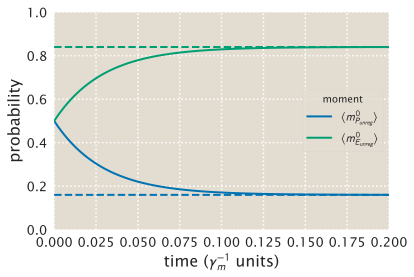

In [118]:
# Define colors for the moments
colors = sns.color_palette('colorblind', n_colors=2)
#Plot the solution of the dynamical equations
plt.plot(t, m0_sol[:, 0], label=r'$\langle m^0_{P_{unreg}}\rangle$',
        color=colors[0])
plt.plot(t, m0_sol[:, 1], label=r'$\langle m^0_{E_{unreg}}\rangle$',
        color=colors[1])
# Plot the steady state solutions
plt.plot(t, [m0_ss[0]] * len(t), color=colors[0], label='', linestyle='--')
plt.plot(t, [m0_ss[1]] * len(t), color=colors[1], label='', linestyle='--')

# Label plot
plt.xlabel('time ($\gamma_m^{-1}$ units)')
plt.ylabel('probability')
# Determine axis span
plt.xlim([t.min(), t.max()])
plt.ylim([0, 1])
# Include legend
plt.legend(title='moment', fontsize=12)

# Save fig
plt.savefig(figdir + 'm0_unreg_dynamics.png', bbox_inches='tight')

### Two-state first moment

Let's proceed to test the first moment.

In [119]:
# Define time on which to perform integration
t = np.linspace(0, 10, 201)

# Define initial conditions
m0_init = [0.5, 0.5]
m1_init = [0, 0]

# Numerically integrate equations
m1_sol = sp.integrate.odeint(dm1dt, m0_init + m1_init, t, 
                             args=(Kmat_unreg, Rmat_unreg, Gmat_unreg))

Let's also compute the steady-state solution.

In [120]:
m1_ss = first_unreg_m(*par_UV5.values())

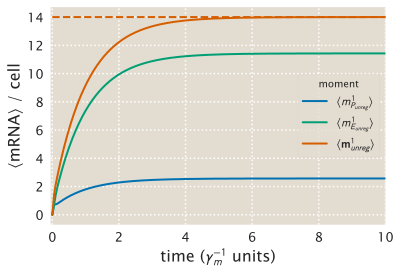

In [122]:
# Define colors for the moments
colors = sns.color_palette('colorblind', n_colors=3)

#Plot the solution
plt.plot(t, m1_sol[:, 2], label=r'$\langle m^1_{P_{unreg}}\rangle$',
        color=colors[0])
plt.plot(t, m1_sol[:, 3], label=r'$\langle m^1_{E_{unreg}}\rangle$',
        color=colors[1])
# Plot the global moment (i.e. the sum of the individual moments)
plt.plot(t, np.sum(m1_sol[:, [2,3]], axis=1), 
        label=r'$\langle \mathbf{m}^1_{unreg}\rangle$',
        color=colors[2])

# Plot the steady state
plt.plot(t, [m1_ss] * len(t), color=colors[2], label='', linestyle='--')


plt.xlabel('time ($\gamma_m^{-1}$ units)')
plt.ylabel(r'$\left\langle\right.$mRNA$\left.\right\rangle$ / cell')
# Determine axis span
plt.xlim([t.min() - 0.05, t.max()])
# Include legend
plt.legend(title='moment', fontsize=12)
# Save fig
plt.savefig(figdir + 'm1_unreg_dynamics.png', bbox_inches='tight')

### Two-state second moment

Let's proceed to test the second moment.

In [124]:
# Define time on which to perform integration
t = np.linspace(0, 10, 201)

# Define initial conditions
m0_init = [0.5, 0.5]
m1_init = [0, 0]
m2_init = [0, 0]

# Numerically integrate equations
m2_sol = sp.integrate.odeint(dm2dt, m0_init + m1_init + m2_init, t, 
                             args=(Kmat_unreg, Rmat_unreg, Gmat_unreg))

# Compute the steady state
m2_ss = second_unreg_m(*par_UV5.values())

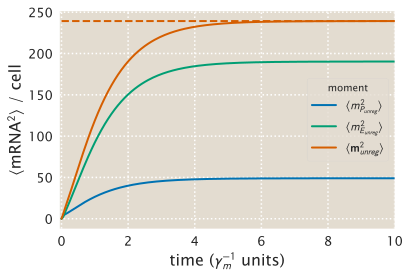

In [127]:
# Define colors for the moments
colors = sns.color_palette('colorblind', n_colors=3)

#Plot the solution
plt.plot(t, m2_sol[:, 4], label=r'$\langle m^2_{P_{unreg}}\rangle$',
        color=colors[0])
plt.plot(t, m2_sol[:, 5], label=r'$\langle m^2_{E_{unreg}}\rangle$',
        color=colors[1])
# Plot the global moment (i.e. the sum of the individual moments)
plt.plot(t, np.sum(m2_sol[:, [4,5]], axis=1), 
        label=r'$\langle \mathbf{m}^2_{unreg}\rangle$',
        color=colors[2])

# Plot the steady state
plt.plot(t, [m2_ss] * len(t), color=colors[2], label='', linestyle='--')


plt.xlabel('time ($\gamma_m^{-1}$ units)')
plt.ylabel(r'$\left\langle\right.$mRNA$^2\left.\right\rangle$ / cell')
# Determine axis span
plt.xlim([t.min() - 0.05, t.max()])
# Include legend
plt.legend(title='moment', fontsize=12)
# Save fig
plt.savefig(figdir + 'm2_unreg_dynamics.png', bbox_inches='tight')

### Two-state third moment

Finally let's integrate the equation for the third moment.

In [128]:
# Define time on which to perform integration
t = np.linspace(0, 10, 201)

# Define initial conditions
m0_init = [0.5, 0.5]
m1_init = [0, 0]
m2_init = [0, 0]
m3_init = [0, 0]

# Numerically integrate equations
m3_sol = sp.integrate.odeint(dm3dt, m0_init + m1_init + m2_init + m3_init, t, 
                             args=(Kmat_unreg, Rmat_unreg, Gmat_unreg))
# Compute the steady state
m3_ss = third_unreg_m(*par_UV5.values())

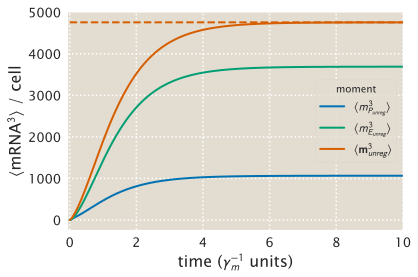

In [130]:
# Define colors for the moments
colors = sns.color_palette('colorblind', n_colors=3)

#Plot the solution
plt.plot(t, m3_sol[:, 6], label=r'$\langle m^3_{P_{unreg}}\rangle$',
        color=colors[0])
plt.plot(t, m3_sol[:, 7], label=r'$\langle m^3_{E_{unreg}}\rangle$',
        color=colors[1])
# Plot the global moment (i.e. the sum of the individual moments)
plt.plot(t, np.sum(m3_sol[:, [6,7]], axis=1), 
        label=r'$\langle \mathbf{m}^3_{unreg}\rangle$',
        color=colors[2])

# Plot the steady state
plt.plot(t, [m3_ss] * len(t), color=colors[2], label='', linestyle='--')


plt.xlabel('time ($\gamma_m^{-1}$ units)')
plt.ylabel(r'$\left\langle\right.$mRNA$^3\left.\right\rangle$ / cell')
# Determine axis span
plt.xlim([t.min() - 0.05, t.max()])
# Include legend
plt.legend(title='moment', fontsize=12)
# Save fig
plt.savefig(figdir + 'm3_unreg_dynamics.png', bbox_inches='tight')

All dynamics converge to the derived steady state value! That gives us confidence that the define dynamics are correctly being integrated.

---

# Three-state promoter

Let's now test the functions for the regulated promoter. In principle we only need the third moment function since it computes the rest of the moments. The reason we wrote them individually was to carefully troubleshoot any complications.

We need to define the parameters for the regulated promoter.

In [134]:
# List the parameters fit for the lacUV5 regulated promoter
par_UV5_reg = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1,
                 Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5)
# Define the k0 parameters in units of the mRNA degradation time
k0_norm = 2.7E-3 / 0.00284 
par_UV5_reg['k0'] = k0_norm

kp_on = par_UV5_reg['kp_on']
kp_off = par_UV5_reg['kp_off']
rm = par_UV5_reg['rm']
gm = par_UV5_reg['gm']
ka = par_UV5_reg['ka']
ki = par_UV5_reg['ki']
epsilon = par_UV5_reg['epsilon']
Nns = par_UV5_reg['Nns']

Let's compute the moments for the $R = 260$ strains and all operators in the absence of inducer.

In [139]:
# Define repressors per cell
rep = 260 
par_UV5_reg['rep'] = rep

# Calculate the repressor on rate including the MWC model
kr_on = k0_norm * rep * chann_cap.p_act(0, ka, ki, epsilon) 
    
# Define energies
operators = ['Oid', 'O1', 'O2', 'O3']
energies = [-17, -15.3, -13.9, -9.7]
energy_dict = dict(zip(operators, energies))

# Define the static matrices for the regulated case
# Define the production matrix
Rmat_reg = np.array([[rm, 0, 0], 
                     [0, 0, 0],
                     [0, 0, 0]])
# Define the degradation matrix
Gmat_reg = np.array([[gm, 0, 0],
                     [0, gm, 0],
                     [0, 0, gm]])

Having defined the parameters that do not depend on the operator let's now loop through operators and integrate the equations.

In [142]:
# Define time on which to perform integration
t = np.linspace(0, 10, 201)

# Define initial conditions
m0_init = [0.3, 0.3, 0.4]
m1_init = [0, 0, 0]
m2_init = [0, 0, 0]
m3_init = [0, 0, 0]

# Initialize dictionary to save the solutions
m_sol = dict()

# Loop through operators integrating the equation at each point
for op in operators:
    eRA = energy_dict[op]
    # Compute the repressor off-rate based on the on-rate and 
    # the binding energy
    kr_off = chann_cap.kr_off_fun(eRA, k0_norm, kp_on, kp_off, Nns)
    # Define the rate constant matrix
    Kmat_reg = np.array([[-kp_off, kp_on, 0], 
                         [kp_off, -(kp_on + kr_on), kr_off],
                         [0, kr_on, -kr_off]])
    # Solve equation 
    m_sol[op] = sp.integrate.odeint(dm3dt, 
                                    m0_init + m1_init + m2_init + m3_init,
                                    t,
                                    args=(Kmat_reg, Rmat_reg, Gmat_reg)) 

Let's now take each of the results and compute the global moments for each operator and save it as a tidy `DataFrame`.

In [151]:
# Initialize DataFrame to save global moments
names = ['time', 'operator', 'energy', 'repressors', 'IPTG', 'm1', 'm2', 'm3']
df_m_sol = pd.DataFrame(columns=names)

# Loop through operators
for op in operators:
    # Extract operator data
    data = m_sol[op]
    # Initialize empty matrix to save data
    mat = np.zeros([data.shape[0], len(names)])
    # Save time array
    mat[:,0] = t
    # Save energy
    mat[:, 2] = [energy_dict[op]] * data.shape[0]
    # Save repressors
    mat[:, 3] = [rep] * data.shape[0]
    # Save IPTG
    mat[:, 4] = [0] * data.shape[0]
    # Compute and save FIRST moment
    mat[:, 5] = np.sum(data[:, 3:6], axis=1)
    # Compute and save SECOND moment
    mat[:, 6] = np.sum(data[:, 6:9], axis=1)
    # Compute and save THIRD moment
    mat[:, 7] = np.sum(data[:, 9::], axis=1)
    # Convert into DataFrame
    df = pd.DataFrame(mat, columns=names)
    # Save operator
    df['operator'] = [op] * data.shape[0]
    # append to dataframe
    df_m_sol = pd.concat([df_m_sol, df], ignore_index=True)
    
df_m_sol.head()

,time,operator,energy,repressors,IPTG,m1,m2,m3
0,0.00,Oid,-17.0,260.0,0.0,0.000000,0.000000,0.000000
1,0.05,Oid,-17.0,260.0,0.0,0.696186,2.984054,16.070559
2,0.10,Oid,-17.0,260.0,0.0,0.833441,4.847093,37.485995
3,0.15,Oid,-17.0,260.0,0.0,0.835247,5.267115,46.909497
4,0.20,Oid,-17.0,260.0,0.0,0.805515,5.090304,47.295085


Having this let's plot all moments

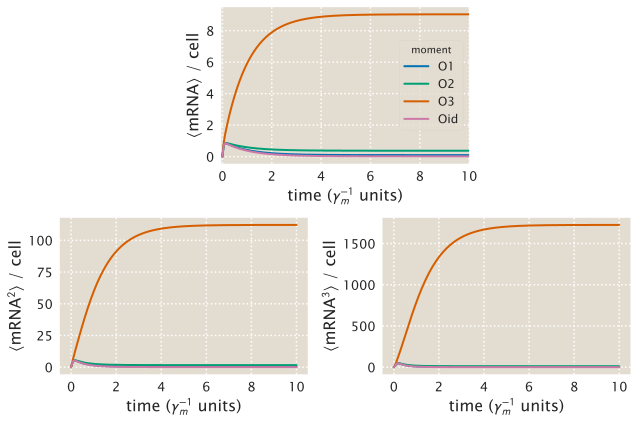

In [172]:
# Group by operator
df_group = df_m_sol.groupby('operator')

# Initialize figure
fig = plt.figure(figsize=(9, 6))

# Define axis to have two on the bottom and one on the top
ax = list()
ax.append(plt.subplot2grid((2, 4), (0, 1), colspan=2, rowspan=1))
ax.append(plt.subplot2grid((2, 4), (1, 0), colspan=2, rowspan=1))
ax.append(plt.subplot2grid((2, 4), (1, 2), colspan=2, rowspan=1))

# Loop through groups
for group, data in df_group:
    # Plot first moment
    ax[0].plot(data['time'], data['m1'], label=group)
    # Plot second moment
    ax[1].plot(data['time'], data['m2'], label=group)
    # Plot third moment
    ax[2].plot(data['time'], data['m3'], label=group)
    
# Label plot
ax[0].set_xlabel('time ($\gamma_m^{-1}$ units)')
ax[1].set_xlabel('time ($\gamma_m^{-1}$ units)')
ax[2].set_xlabel('time ($\gamma_m^{-1}$ units)')

ax[0].set_ylabel(r'$\left\langle\right.$mRNA$\left.\right\rangle$ / cell')
ax[1].set_ylabel(r'$\left\langle\right.$mRNA$^2\left.\right\rangle$ / cell')
ax[2].set_ylabel(r'$\left\langle\right.$mRNA$^3\left.\right\rangle$ / cell')
# # Determine axis span
ax[0].set_xlim([t.min() - 0.05, t.max()])
# # Include legend
ax[0].legend(title='moment', fontsize=12)
plt.tight_layout()
# Save figure
plt.savefig(figdir + 'm_reg_dynamics.png', bbox_inches='tight')